In [3]:
import matplotlib.pylab as plt

import tensorflow as tf

In [4]:
import tensorflow_hub as hub

from tensorflow.keras import layers

In [5]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [6]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

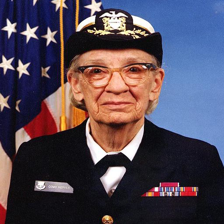

In [7]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [8]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [9]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

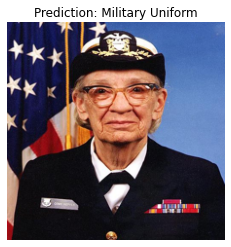

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [13]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [14]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [15]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [16]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [17]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pinwheel', 'pot', 'barn spider', 'daisy', 'rapeseed',
       'matchstick', 'porcupine', 'fly', 'cardoon', 'goblet', 'daisy',
       'daisy', 'sea urchin', 'coral fungus', 'feather boa', 'sea urchin',
       'quill', 'bee', 'sea urchin', 'ant', 'groom', 'coral fungus',
       'daisy', 'picket fence', 'grasshopper', 'cardoon', 'daisy',
       'sea urchin', 'picket fence', 'daisy', 'daisy', 'grasshopper'],
      dtype='<U30')

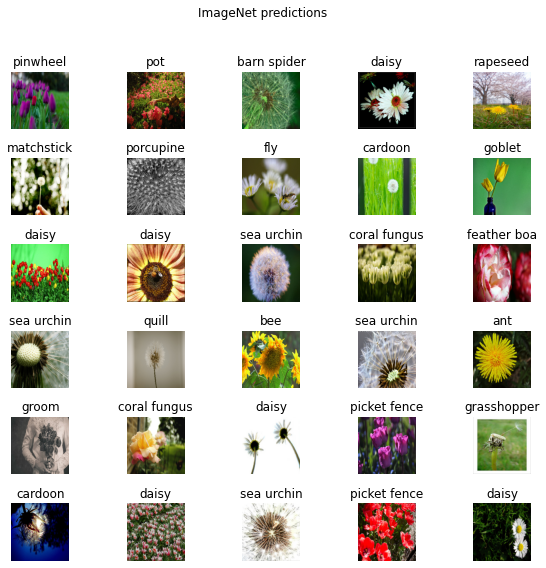

In [18]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [19]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [20]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [21]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [22]:
feature_extractor_layer.trainable = False

In [23]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
predictions = model(image_batch)

In [25]:
predictions.shape

TensorShape([32, 5])

In [26]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [27]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [28]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

c:\Users\jinhee\.conda\envs\readvice\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
115/115 [==============================] - 12s 79ms/step - loss: 0.4334 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 9s 80ms/step - loss: 0.3221 - acc: 0.8750


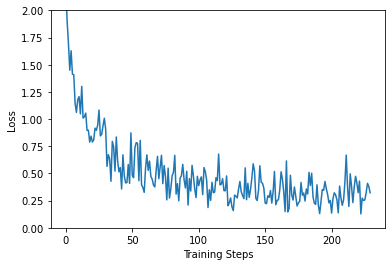

In [29]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

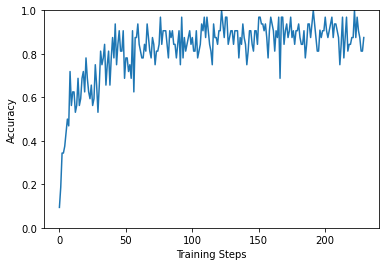

In [30]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [31]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [32]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [33]:
label_id = np.argmax(label_batch, axis=-1)

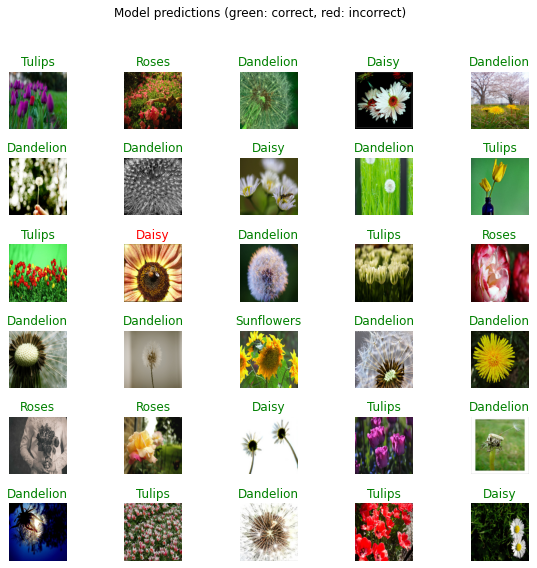

In [34]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [35]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1656500131\assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1656500131\assets


'/tmp/saved_models/1656500131'

In [36]:
reloaded = tf.keras.models.load_model(export_path)

In [37]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [38]:
abs(reloaded_result_batch - result_batch).max()

0.0